In [5]:
from dotenv import load_dotenv
import os
load_dotenv()
pinecone_api_key = os.getenv("PINECONE_API_KEY")

# index 생성

In [6]:
from pinecone import Pinecone
# 클라이언트 생성
pinecone_client = Pinecone(api_key=pinecone_api_key)

In [7]:
pinecone_client

## 클라이언트.create_index

In [5]:
from pinecone import ServerlessSpec
pinecone_client.create_index(
    name='embedding-3d',
    dimension=3,
    metric='cosine',
    spec=ServerlessSpec(
        cloud='aws',
        region='us-east-1'
    )
)

{
    "name": "embedding-3d",
    "metric": "cosine",
    "host": "embedding-3d-te99u8p.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 3,
    "deletion_protection": "disabled",
    "tags": null
}

In [8]:
index = pinecone_client.Index('embedding-3d')
index

c:\Users\Admin\miniconda3\envs\prompting_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

In [9]:
for ids in index.list(namespace='embedding-3d-ns1'):
    print(ids)

# pinecone data 형식
```
[
    {'id': 'vec1', 'values': [1.0, 1.5, 2.0], 'metadata': {'genre':'drama'}},
    {'id': 'vec2', 'values': [2.0, 1.5, 0.5], 'metadata': {'genre':'action'}},
    {'id': 'vec3', 'values': [0.1, 0.3, 0.5], 'metadata': {'genre':'drama'}},
    {'id': 'vec4', 'values': [1.0, 2.5, 3.5], 'metadata': {'genre':'action'}},
    {'id': 'vec5', 'values': [3.0, 1.2, 1.3], 'metadata': {'genre':'action'}},
    {'id': 'vec6', 'values': [0.3, 1.1, 2.5], 'metadata': {'genre':'drama'}},
]
```

In [10]:
index.upsert(
    vectors=[
        {'id': 'vec1', 'values': [1.0, 1.5, 2.0], 'metadata': {'genre':'drama'}},
        {'id': 'vec2', 'values': [2.0, 1.5, 0.5], 'metadata': {'genre':'action'}},
        {'id': 'vec3', 'values': [0.1, 0.3, 0.5], 'metadata': {'genre':'drama'}},
        {'id': 'vec4', 'values': [1.0, 2.5, 3.5], 'metadata': {'genre':'action'}},
        {'id': 'vec5', 'values': [3.0, 1.2, 1.3], 'metadata': {'genre':'action'}},
        {'id': 'vec6', 'values': [0.3, 1.1, 2.5], 'metadata': {'genre':'drama'}},
    ],
    namespace='embedding-3d-ns1'
)  # update + insert

{'upserted_count': 6}

In [9]:
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'embedding-3d-ns1': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}

# id list

In [10]:
for ids in index.list(namespace='embedding-3d-ns1'):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


# query

In [ ]:
response = index.query(
    namespace='embedding-3d-ns1',
    vector=[0.1, 0.4, 0.7],   # 질의 벡터
    top_k=3,     # 가져올 결과 개수
    include_values=True,
    include_metadata=True,
    filter={'genre':{'$eq':'drama'}}
)
response

{'matches': [{'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 1.00008953,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.99550879,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec1',
              'metadata': {'genre': 'drama'},
              'score': 0.961182,
              'values': [1.0, 1.5, 2.0]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 1}}

In [12]:
ns = 'embedding-3d-ns1'
for ids in index.list(namespace=ns):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


# fetch

In [14]:
from itertools import chain
all_ids = list(chain.from_iterable(index.list(namespace=ns)))
resp = index.fetch(ids=all_ids, namespace=ns)

In [15]:
resp.vectors

{'vec5': Vector(id='vec5', values=[3.0, 1.2, 1.3], metadata={'genre': 'action'}, sparse_values=None),
 'vec4': Vector(id='vec4', values=[1.0, 2.5, 3.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec6': Vector(id='vec6', values=[0.3, 1.1, 2.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec2': Vector(id='vec2', values=[2.0, 1.5, 0.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None)}

In [16]:
for vid, v in resp.vectors.items():
    vid, v.values

# page - 1개 벡터씩 꺼내기

In [19]:
for id_page in index.list(namespace=ns):
    resp = index.fetch(ids=id_page, namespace=ns)
    
    for vid, v in resp.vectors.items():
        print(vid, v.values)
    

vec4 [1.0, 2.5, 3.5]
vec3 [0.1, 0.3, 0.5]
vec2 [2.0, 1.5, 0.5]
vec6 [0.3, 1.1, 2.5]
vec1 [1.0, 1.5, 2.0]
vec5 [3.0, 1.2, 1.3]


# 새로운 쿼리벡터 추가

In [21]:
ids = list(resp.vectors.keys())
values = [vec.values for vec in resp.vectors.values()]

In [22]:
ids.append('qv')
values.append([0.1, 0.3, 0.7])

# 시각화

In [ ]:
!pip install matplotlib

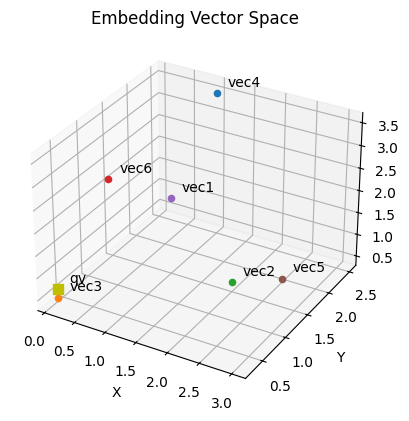

In [24]:
import matplotlib.pyplot as plt

# 3D 플롯을 생성합니다.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 벡터의 ID와 값을 사용하여 3D 공간에 점을 그립니다.
for i, id in enumerate(ids):
    if id == "qv":
        # 쿼리 벡터는 노란색 사각형으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id, color='y', s=50, marker='s')
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)
    else:
        # 나머지 벡터는 기본 색상으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id)
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)

# 축 레이블과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Embedding Vector Space')

# 플롯을 표시합니다.
plt.show()

name: "quickstart" 서버리스 인덱스 생성  
dim: 1024

In [25]:
from pinecone import ServerlessSpec
pinecone_client.create_index(
    name='quickstart',
    dimension=1024,
    metric='cosine',
    spec=ServerlessSpec(
        cloud='aws',
        region='us-east-1'
    )
)

{
    "name": "quickstart",
    "metric": "cosine",
    "host": "quickstart-te99u8p.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 1024,
    "deletion_protection": "disabled",
    "tags": null
}

In [26]:
index_quickstart = pinecone_client.Index('quickstart')
index_quickstart

In [31]:
data = [
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."},
    {"id": "vec7", "text": "사과 파이는 따뜻한 향과 바삭한 크러스트로 많은 이들의 디저트로 사랑받습니다."},
    {"id": "vec8", "text": "애플은 iOS 운영체제와 앱 스토어로 모바일 생태계를 구축했습니다."},
    {"id": "vec9", "text": "사과에는 식이섬유와 비타민 C가 풍부해 상큼하고 포만감을 줍니다."},
    {"id": "vec10", "text": "애플의 맥북은 가벼운 무게와 긴 배터리 시간으로 휴대성이 좋다고 평가됩니다."},
    {"id": "vec11", "text": "가을이면 과수원에서 잘 익은 사과를 직접 수확하는 체험이 인기를 끕니다."},
    {"id": "vec12", "text": "애플 워치는 건강 측정과 알림 기능으로 일상 생활에서 자주 활용됩니다."},
    {"id": "vec13", "text": "사과즙과 애플 사이다 식초는 요리와 음료에 다양하게 사용됩니다."},
    {"id": "vec14", "text": "애플은 하드웨어와 소프트웨어, 서비스를 긴밀히 통합한 생태계 전략을 펼칩니다."},
    {"id": "vec15", "text": "사과를 껍질째 먹으면 식이섬유 섭취량을 더 늘릴 수 있습니다."}
]

임베딩 모델   
- multilingual-e5-large
- upsert()
- describe_index_stats()
- query_vector: "애플이라는 기술 회사에 대해 알려주세요"
- index.query()

In [29]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("intfloat/multilingual-e5-large")

c:\Users\Admin\miniconda3\envs\prompting_env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--intfloat--multilingual-e5-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back

In [ ]:
change = [f"change: {d['text']}" for d in data]
embeddings = model.encode(change, normalize_embeddings=True).tolist()
len(embeddings[0])

1024

In [33]:
vectors = [
    {"id": d["id"], "values": e, "metadata": {"text": d["text"]}}
    for d, e in zip(data, embeddings)
]

In [34]:
index_quickstart.upsert(vectors=vectors, namespace="quickstart-ns1")

{'upserted_count': 15}

In [35]:
index_quickstart.describe_index_stats()

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'quickstart-ns1': {'vector_count': 15}},
 'total_vector_count': 15,
 'vector_type': 'dense'}

In [40]:
query_vector = "애플이라는 기술 회사에 대해 알려주세요"
emb = model.encode(f"query: {query_vector}", normalize_embeddings=True).tolist()

res = index_quickstart.query(
    vector=emb,
    top_k=3,
    include_metadata=True,
    namespace="quickstart-ns1"
)

res

{'matches': [{'id': 'vec2',
              'metadata': {'text': '애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.'},
              'score': 0.897493362,
              'values': []},
             {'id': 'vec4',
              'metadata': {'text': '애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 '
                                   '혁신했습니다.'},
              'score': 0.88274765,
              'values': []},
             {'id': 'vec6',
              'metadata': {'text': '애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, '
                                   '로널드 웨인에 의해 파트너십으로 설립되었습니다.'},
              'score': 0.866777301,
              'values': []}],
 'namespace': 'quickstart-ns1',
 'usage': {'read_units': 1}}